# Car Logo Convolutional Neural Network - meet CarL-CNN
As a capstone project for my Data Science Bootcamp, I thought up to create a car logo classifier using a convolutional neural network. The project was divided into several phases:

* Building my own dataset - as similar projects (image classifiers) are already abundant, I wanted to make my own stand out at least a little bit. So I thought of building my own dataset of car manufacturer logotypes. What I did was I wrote a script scraping the Google image finder by providing it the brand names and some additional search queries, like "%brand% logo", "%brand% logotype", "%brand% logo black" and so on. I feeded it with 40 car manufacturer names and 10 logo-like queries and started the engine. Vroom...
... (time passed)
* That didn't pan out too well, though, as I managed to collect 1,100 images per brand, so 44,000 pictures. However, what I instantly saw was that Google didn't care enough to give me only car logos. Search terms which I thought were precise enough, returned unexpected results. Majority of the results were okay, although of different sizes and resolutions, but they also came in pairs or triplets - depending on the car manufacturer capital liaisons (Dacia often with Renault, Kia/Hyundai, too and don't even get me started on the Volkswagen Group, sporting VW, Audi, Skoda, Porsche and Seat in various combinations). Many results brought up some car-related gadgets, plaques and even tuning parts - I accepted them only if they carried a logo - others, were deleted. Moreover, the collection was not evenly spread between the brands - Rover brought about 200 entries with the Land Rover logo, less popular cars hardly crossed 300 proper results and so on. My dataset was about to be biased. Hard...

* Clearing up this mess took a whole weekend of hand-picking only the pictures actually showing a logotype and of the correct car brand. I ended up with exactly 20,778 "good" pictures, so some 47% success - yay, Google...

* Since less than a 21K worth of unevenly distributed dataset is not too big, I had to make a salvation through some heavy data augmentation. Fortunately, there is a PIL module with its powerful Image package. On top of that, Keras ImageDataGenerator easily multiplicated virtually my tiny dataset to over 100K when training - at least a number that isn't embarrassing.

* Building the CNN - of course I could get the latest state-of-the-art CNN, like Inception4 or ResNet. There are already trained weights available on github and that would take like 15 minutes to do. But I wanted to go the hard way, after all, I am still learning, so perhaps my network should, too...So I put together my CNN on my own, loosely inspired by VGG19, in hopes for some 70% of accuracy at least. I even gave it a name - CarL-CNN - as an acronym of Car Logotypes CNN. And then the fun started...

* First, the network resisted to be learning at all. Consecutive epochs brought up lower acc and higher val_loss, which shouldn't happen at all. Then, it had problems with surpassing 72-73% of accuracy - I tried several things, but ultimately only the data augmentation alone boosted it to 80% and also helped diminishing the loss on the validitation set, during training.

* Overall, the ultimate accuracy reached by CarL was over 94%, with somewhat visible differences between the classes (less populous datasets were naturally recognized worse).

* Putting the elements together - my image classifier was ready to be put together. I wrote a ShowCase() method to demonstrate its utility and drank coffee - for the first time with satisfaction :) But that was not enough after a while. How would my CNN behave when provided with a totally new, never seen picture? I had to find out - I went down to the garage and took a picture of every car there. High resolution files will surely behave differently, I thought. Well... it passed the test clean :)

* After a while, I added another small feature - examining the badly recognized ones. What was the most likely reason for CarL to fail? Which brands were mistaken for which most often? Is there a pattern I could find to fix it? Let's see...

# Scraping the web - in search for some decent logos

In [1]:
# Importing the modules for collecting and building the dataset
import time
import os
import re

# Web-scraping...
from urllib.request import Request, urlopen
from urllib.request import URLError, HTTPError

# Image processing...
from PIL import Image


In [2]:
# Scraping the Google image resources - unquote this part of code if you want to go through hand-picking hell yourself


cars = ['Alfa Romeo', 'Audi', 'BMW', 'Chevrolet', 'Citroen', 'Dacia', 'Daewoo', 'Dodge',
        'Ferrari', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Lada',
        'Lancia', 'Land Rover', 'Lexus', 'Maserati', 'Mazda', 'Mercedes', 'Mitsubishi',
        'Nissan', 'Opel', 'Peugeot', 'Porsche', 'Renault', 'Rover', 'Saab', 'Seat',
        'Skoda', 'Subaru', 'Suzuki', 'Tata', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']

kwrds = ['logo', 'logotype', 'logo png', 'logo gif', 'logo jpg', 'logo front',
         'logo rear', 'badge', 'logo white', 'logo black', 'logo transparent']
"""
def scrape(link):
    try:
        headers = {}
        headers['User-Agent'] = "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36"
        return str(urlopen(Request(link, headers = headers)).read())
    except Exception as e:
        print(str(e))

# function that will get the url of the image to download
def get_logo(l):
    line = l.find('"class="rg_meta"')
    start = l.find('"ou"', line + 1)
    end = l.find(',"ow"', start + 1)
    raw = str(l[start + 6:end - 1])
    return raw, end

def get_all_logos(page):
    items = []
    while True:
        item, p = get_logo(page)
        if item == "no_links":
            break
        else:
            items.append(item)
            time.sleep(0.1)
            page = page[p:]
    return items

# Beginning the download
i = 0
while i < len(cars):
    
    items = []
    car = cars[i].replace(' ', '%20')
    os.makedirs(cars[i])
    
    j = 0
    while j < len(kwrds):
        search_term = kwrds[j].replace(' ','%20')
        url = 'https://www.google.com/search?q=' + car + search_term + '&espv=2&biw=1366&bih=667&site=webhp&source=lnms&tbm=isch&sa=X&ei=XosDVaCXD8TasATItgE&ved=0CAcQ_AUoAg'
        raw =  scrape(url)
        time.sleep(0.1)
        items = items + (get_all_logos(raw))
        j+=1

    k = 0
    while k < len(items):
        try:
            req = Request(items[k], headers={"User-Agent": "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"})
            response = urlopen(req,None,15) # specyfing the timeout (Google often has problems with images)
            output_file = open(cars[i] + "/" + str(k+1) + '.jpg','wb')
            output_file.write(response.read())
            response.close();
            k+=1
        except:
            print("Error!")
            k+=1
    i+=1

print("Done. Files downloaded. Happy handpicking!")
"""

'\ndef scrape(link):\n    try:\n        headers = {}\n        headers[\'User-Agent\'] = "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36"\n        return str(urlopen(Request(link, headers = headers)).read())\n    except Exception as e:\n        print(str(e))\n\n# function that will get the url of the image to download\ndef get_logo(l):\n    line = l.find(\'"class="rg_meta"\')\n    start = l.find(\'"ou"\', line + 1)\n    end = l.find(\',"ow"\', start + 1)\n    raw = str(l[start + 6:end - 1])\n    return raw, end\n\ndef get_all_logos(page):\n    items = []\n    while True:\n        item, p = get_logo(page)\n        if item == "no_links":\n            break\n        else:\n            items.append(item)\n            time.sleep(0.1)\n            page = page[p:]\n    return items\n\n# Beginning the download\ni = 0\nwhile i < len(cars):\n    \n    items = []\n    car = cars[i].replace(\' \', \'%20\')\n    os.makedirs(cars[i])\n    \n    j 

# Working with images

In [3]:
# Importing standard ML set - numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Importing keras and its deep learning tools - neural network model, layers, contraints, optimizers, callbacks and utilities
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras.initializers import RandomNormal, VarianceScaling

# Importing scikit-learn tools
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [4]:
# Setting up the image pool
image_path = 'images/'
imgs = os.listdir(image_path)
img_x = img_y = 50 # image size is constant
n_samples = np.size(imgs)
n_samples # 20778 originally

20778

In [5]:
# Loading all images...
images = np.array([np.array(Image.open(image_path + img).convert("RGB")).flatten() for img in os.listdir(image_path)], order='F', dtype='uint8')
np.shape(images)

(20778, 7500)

In [6]:
# an example image
images[1][1:]

array([255, 255, 249, ..., 255, 255, 255], dtype=uint8)

In [7]:
# Producing labels and assigning them accordingly
labels = np.array([cars.index(re.match(r"(^\D+)", imgs[i])[0]) for i in range(n_samples)])
labels.shape

(20778,)

In [8]:
# Some additional data preparation needs to be done before blasting the images into the neural net
dataset, labelset = shuffle(images, labels, random_state=42) # 42, what else? ;)
train_data = [dataset, labelset]

(20778, 7500) (20778,)


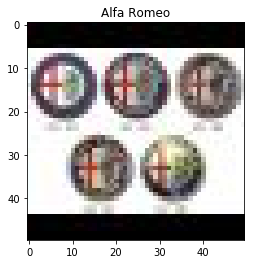

In [9]:
# Testing if the images loaded up okay - 500 should show Alfa Romeo label and a five-logo image
r = 500
print(train_data[0].shape, train_data[1].shape)
plt.imshow(images[r].reshape(img_x, img_y, 3))
plt.title(cars[labels[r]])
plt.show()

# Training - preparing the dataset

In [10]:
# We have to prepare the dataset to fit into the CNN
X_train, X_test, y_train, y_test = train_test_split(train_data[0], train_data[1], test_size=0.2)

# we will maintain a copy of the test set, as we will do a couple of transformation to it
X_test_img = X_test.copy()

# let's bring back the images, like above
X_train = X_train.reshape(X_train.shape[0], img_x, img_y, 3)
X_test = X_test.reshape(X_test.shape[0], img_x, img_y, 3)

# Now for some convergence-friendly procedure (is supposed to converge a lot faster when brought to 0-1 float)...
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# ...and some additional pre-processing, to zero-center the data...
X_train = np.subtract(X_train, 0.5)
X_test = np.subtract(X_test, 0.5)

# ...and to scale it to (-1, 1)
X_train = np.multiply(X_train, 2.0)
X_test = np.multiply(X_test, 2.0)

# Labels have to be transformed to categorical
Y_train = np_utils.to_categorical(y_train, num_classes=len(cars))
Y_test = np_utils.to_categorical(y_test, num_classes=len(cars))

In [11]:
# All should be okay, but we still need some heavy data augmentation, as 20k samples with 40 labels is a bit too few...
X_train.shape, X_test.shape

((16622, 50, 50, 3), (4156, 50, 50, 3))

# Data augmentation

In [12]:
# In order to process data augmentation, keras' ImageDataGenerator can apply some transformations to images on random
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=True,
    # samplewise_std_normalization=True,
    # zca_whitening=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [13]:
# It has to be 'fit' into the training set, which will take a while...
datagen.fit(X_train)

# Building the CNN model

In [14]:
# Finally for some CNN construction!

# setting up batch size
batch = 128

# there are 40 brands altogether, so far, but let's make it official
n_classes = len(cars)

# setting up the number of epochs to be trained
n_epochs = 200

# images are RGB, so they use up 3 channels for Red, Green and Blue, respectively
n_channels = 3

In [15]:
# Convolutional Neural Network will be composed of four Conv/MaxPool blocks, a flattening layer and two dense layers at the end
# (before the final classification layer, that is)

# The model will have a sequential architecture
# NOTE: kernel and bias had to be fine-tuned in order to increase the chance of converging

model = Sequential()
model.add(Conv2D(32, (3,3),
                 input_shape=(img_x,img_y,n_channels),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

# final activation is softmax, tuned to the number of classes/labels possible
model.add(Dense(len(cars), activation='softmax'))

# Some callbacks have to be provided to choose the best trained model
# patience set at 4 as 3 was too greedy - I observed better results after the third-worse epoch
early_stopping = EarlyStopping(patience=4, monitor='val_loss')
CNN_file = 'car_CNN_13AUGM_CMCMCMCMF.h5py' # the 13th try, with augmented data
take_best_model = ModelCheckpoint(CNN_file, save_best_only=True)

# optimizer will be a stochastic gradient descent, learning rate set at 0.005
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])

# Let's look at the summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         295168    
__________

# Applying ImageDataGenerator - training with the augmented dataset
A note has to be made here: I tried to use the regular .fit() method, but probably due to unbalanced and relatively small dataset, it reached the accuracy of some 72%-73% at best, with the loss on the validation set at some 1.2 at best.
Using the virtually augmented dataset boosted the accuracy score beyond 80% and lowered the val_loss parameter below 1.0. I assumed and saved the best trained model.

In [16]:
# Training time was around 4 minutes per epoch, restarting a few times - over 16 hours overall
"""model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch, shuffle=True, seed=42),\
                    steps_per_epoch=X_train.shape[0]//batch, epochs=n_epochs,\
                    validation_data=(X_test, Y_test), workers=4)"""

'model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch, shuffle=True, seed=42),                    steps_per_epoch=X_train.shape[0]//batch, epochs=n_epochs,                    validation_data=(X_test, Y_test), workers=4)'

In [17]:
# that 'little' file (~145MB) just cost me 16 hours to produce, so it's better to load it now
model.load_weights('car_CNN_13AUGM_CMCMCMCMF.h5py')

In [18]:
X_train.shape

(16622, 50, 50, 3)

In [19]:
# I will need that later to re-convert my flattened images to their previous state
def ImageConvert(n, i):
    im_ex = i.reshape(n, img_x, img_y, 3)
    im_ex = im_ex.astype('float32') / 255
    im_ex = np.subtract(im_ex, 0.5)
    im_ex = np.multiply(im_ex, 2.0)
    return im_ex

In [20]:
# Just for reference, I leave the output of the regular (no augmentation) .fit()

In [21]:
# model.fit(X_train, Y_train, batch_size=batch, shuffle=True, epochs=n_epochs, verbose=1, validation_data=(X_test, Y_test),
#          callbacks=[early_stopping, take_best_model])
# model.load_weights(CNN_file)

In [22]:
scores = model.evaluate(X_test, Y_test) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

4156/4156 [==============================] - 18s    
Accuracy test: 94.42%


# Metrics of success

In [23]:
from sklearn.metrics import precision_recall_fscore_support as prfs

# Preparing for metrics check-up on the test set, may take a while...
Y_pred = model.predict_classes(X_test)

4156/4156 [==============================] - 17s    


In [24]:
precision, recall, f1, support = prfs(y_test, Y_pred, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}\nAccuracy: {:.2%}".format(precision, recall, f1, scores[1]))

Precision: 94.55%
Recall: 94.42%
F1 score: 94.43%
Accuracy: 94.42%


In [25]:
# But let's check per class, too - assuming that larger datasets will be having higher metrics
precision_, recall_, f1_, support_ = prfs(y_test, Y_pred, average=None)

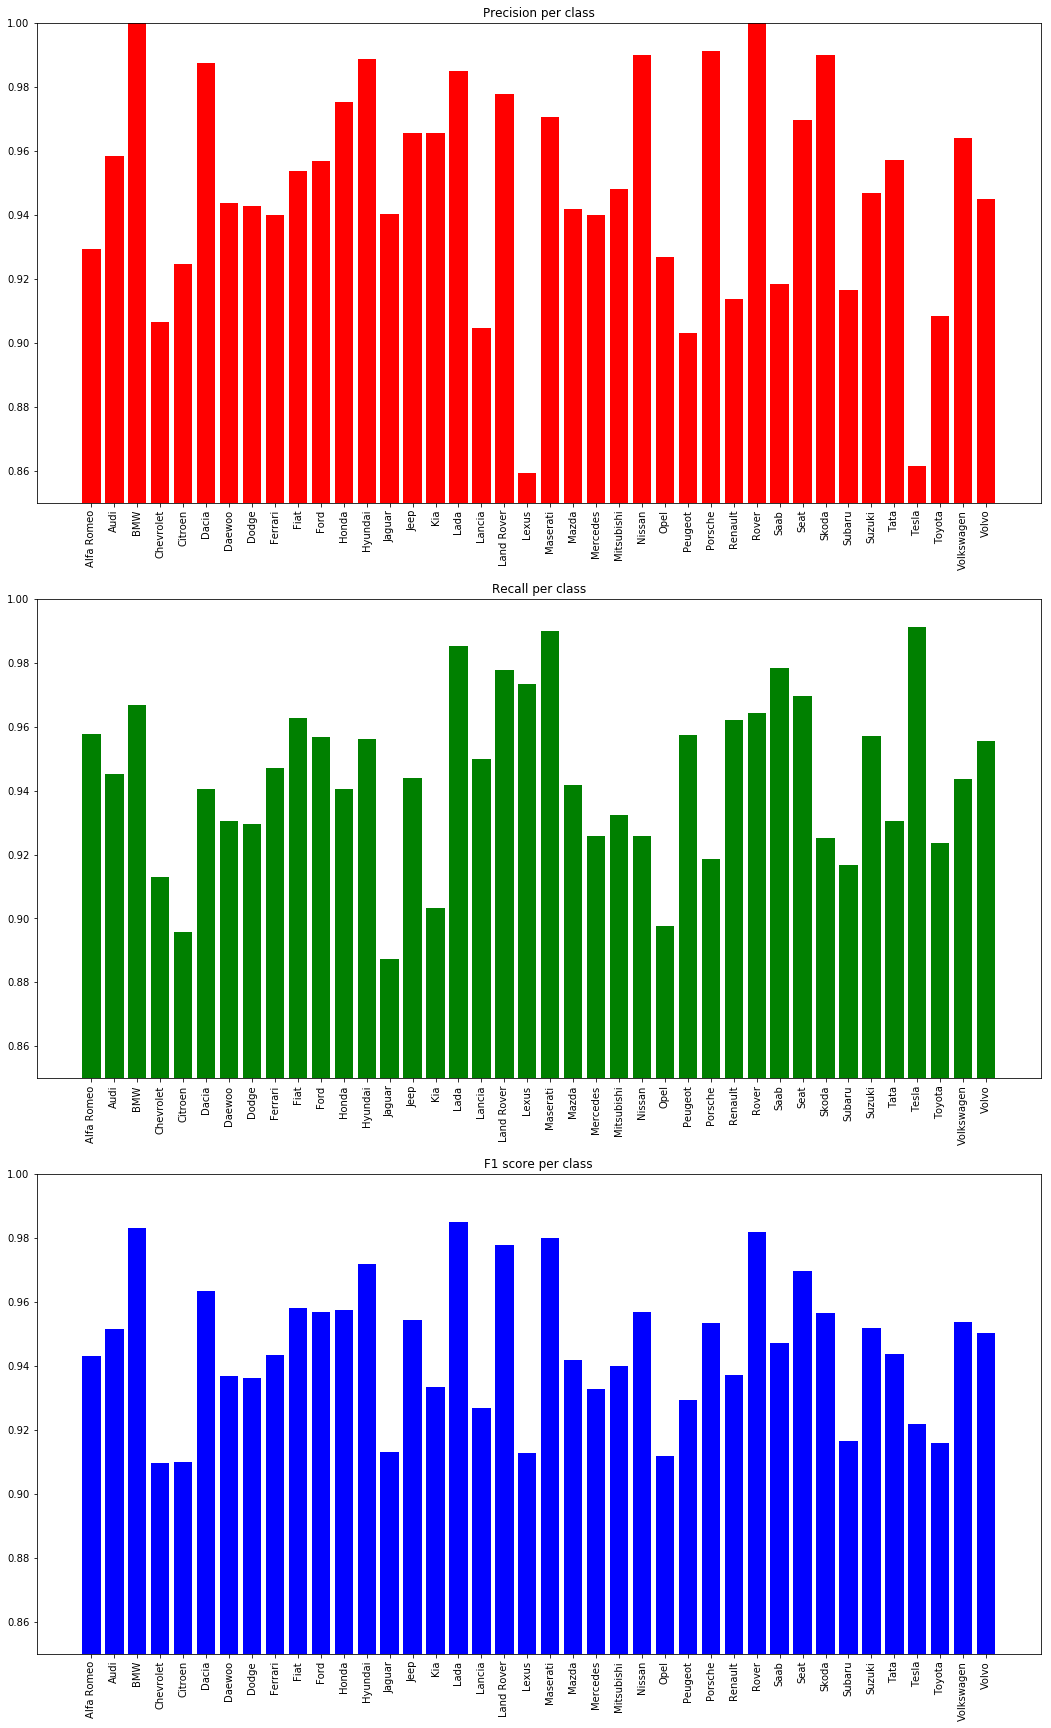

In [26]:
# We see that smaller sets (Lexus, Jaguar, Hyundai) have generally worse precision and recall
plt.subplots(figsize=(18,30))
x = range(len(cars))
plt.subplot(311)
plt.title('Precision per class')
plt.ylim(0.85, 1.00)
plt.bar(x, precision_, color='Red')
plt.xticks(x, cars, rotation = 90)
plt.subplot(312)
plt.title('Recall per class')
plt.ylim(0.85, 1.00)
plt.bar(x, recall_, color='Green')
plt.xticks(x, cars, rotation = 90)
plt.subplot(313)
plt.title('F1 score per class')
plt.ylim(0.85, 1.00)
plt.bar(x, f1_, color='Blue')
plt.xticks(x, cars, rotation = 90)
plt.show()

# Showcasing

In [68]:
# OK, let's try the CNN in action - first defining the ShowCase() method to show everything nicely

def ShowCase(cols, rows):
    fdict = {'fontsize': 24,
            'fontweight' : 'normal',
            'verticalalignment': 'baseline'}
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    c = 0
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        
        # r - randomly picked from the whole dataset
        r = np.random.randint(np.shape(images)[0])
        
        # j - predicted class for the image of index r (weird syntax, but works :)
        j = int(model.predict_classes(ImageConvert(1, images[r:r+1]), verbose=0))
        
        # increase success if predicted well
        if labels[r] == j:
            c += 1
        
        # image needs reshaping back to a 50px*50px*RGB
        plt.imshow(images[r].reshape(img_x, img_y, 3))
        
        # plt.title will show the true brand and the predicted brand
        plt.title('True brand: '+cars[labels[r]]+'\nPredicted: '+cars[j],
                  color= 'Green' if cars[labels[r]] == cars[j] else 'Red', fontdict=fdict) # Green for right, Red for wrong
        
        # no ticks
        plt.xticks(())
        plt.yticks(())
        
    # print out the success rate
    print('Success rate: {}/{} ({:.2%})'.format(c, rows*cols, c/(rows*cols)))
    
    plt.show()

Success rate: 46/50 (92.00%)


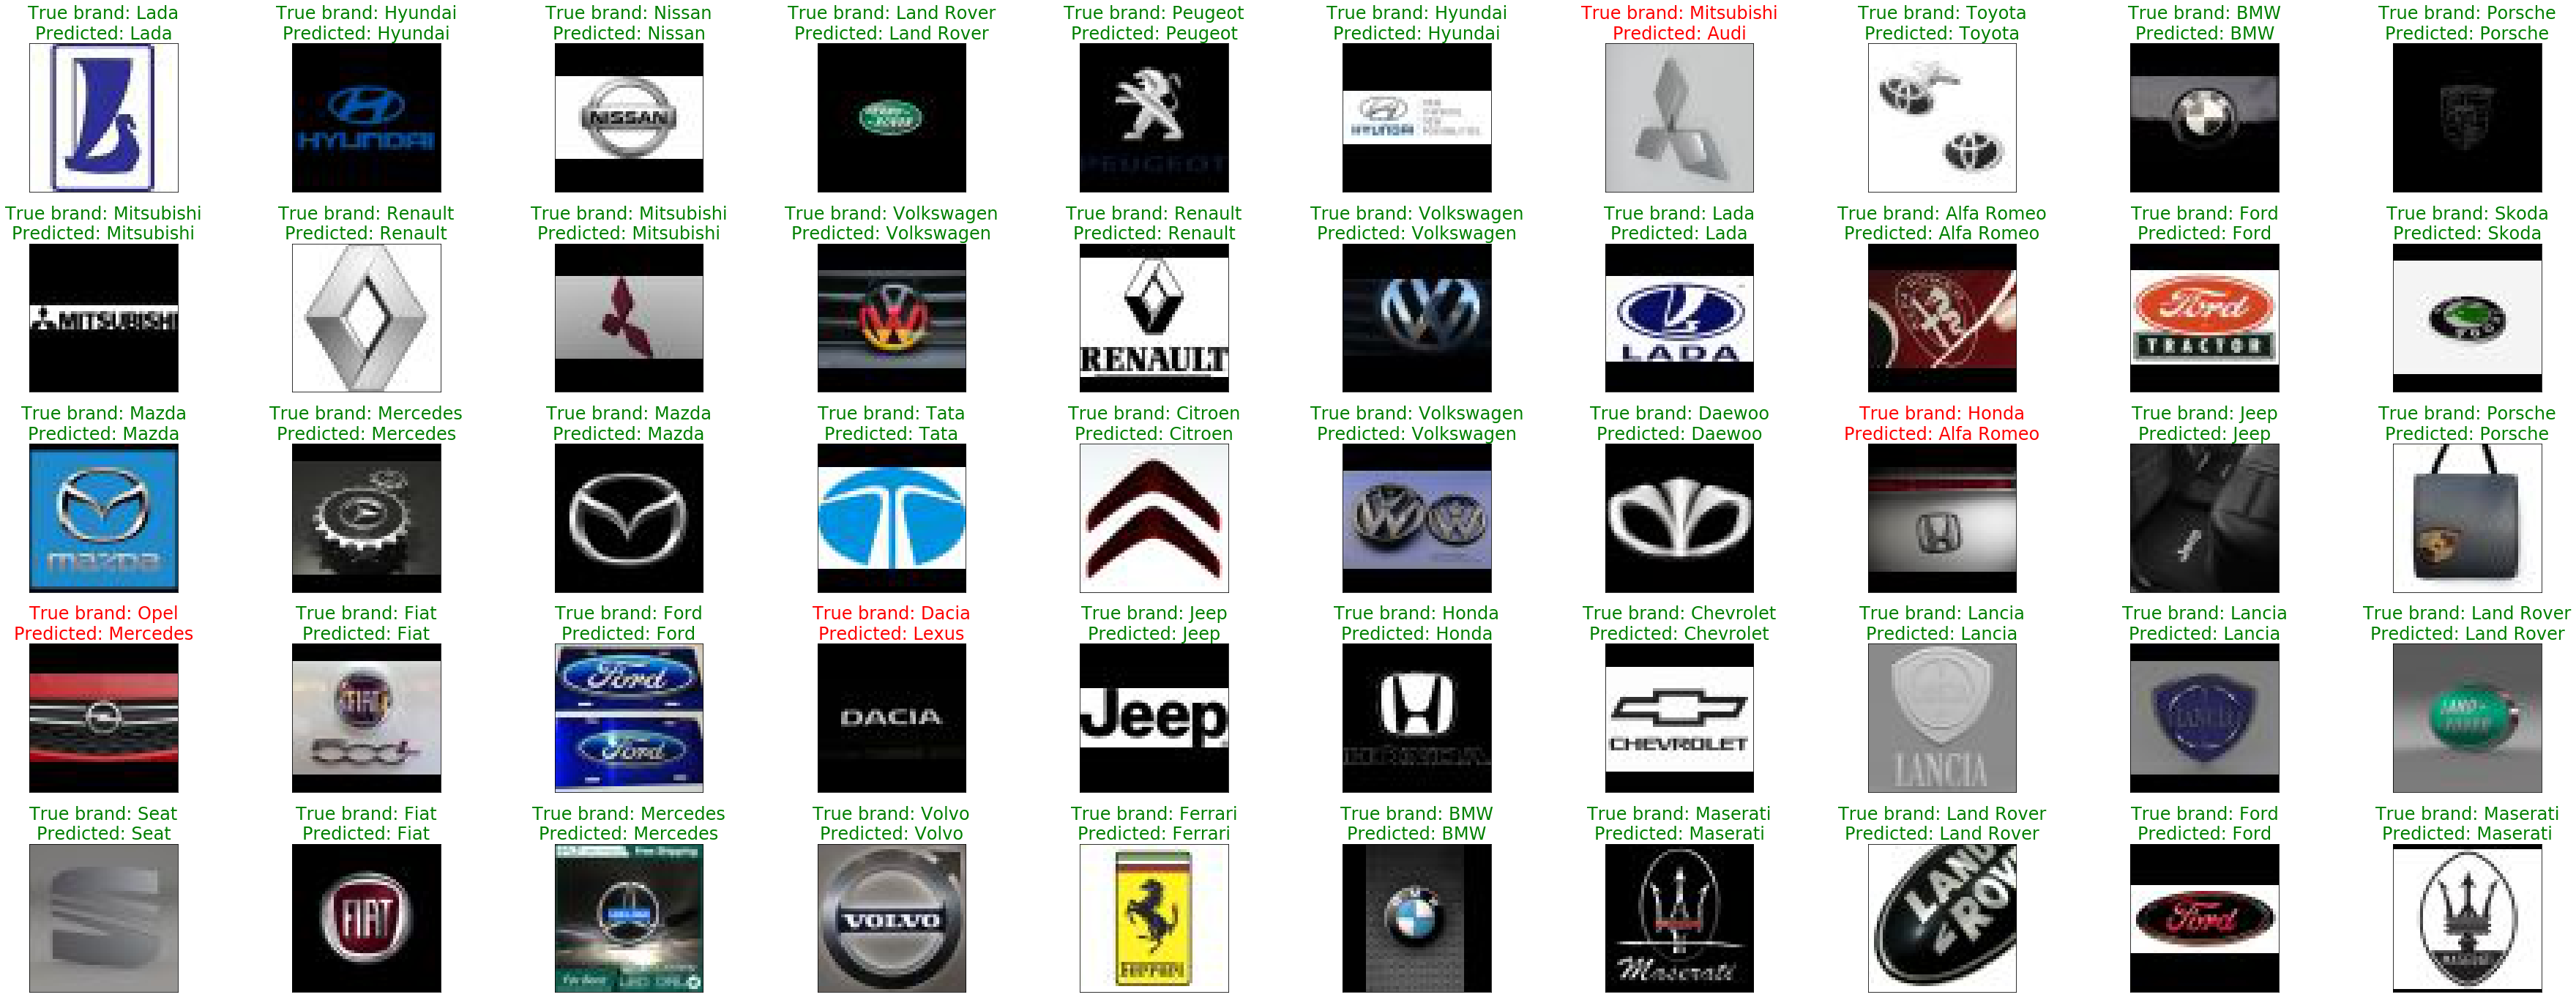

In [69]:
# That is strictly for the showcasing, how the CNN works - ain't that bad, after all :)
ShowCase(10, 5)

# New input - testing beyond the test set

Let's try to test CarL-CNN in the wild - I went down to the garage and took a picture of every car there. I tried to acquire pictures from different angles and with different lighting. I put it into the new_images folder, never touched by CarL.

In [29]:
# Setting up the image pool
new_image_path = 'new_images/'
new_imgs = os.listdir(new_image_path)
new_n_samples = np.size(new_imgs)
new_n_samples # 8

8

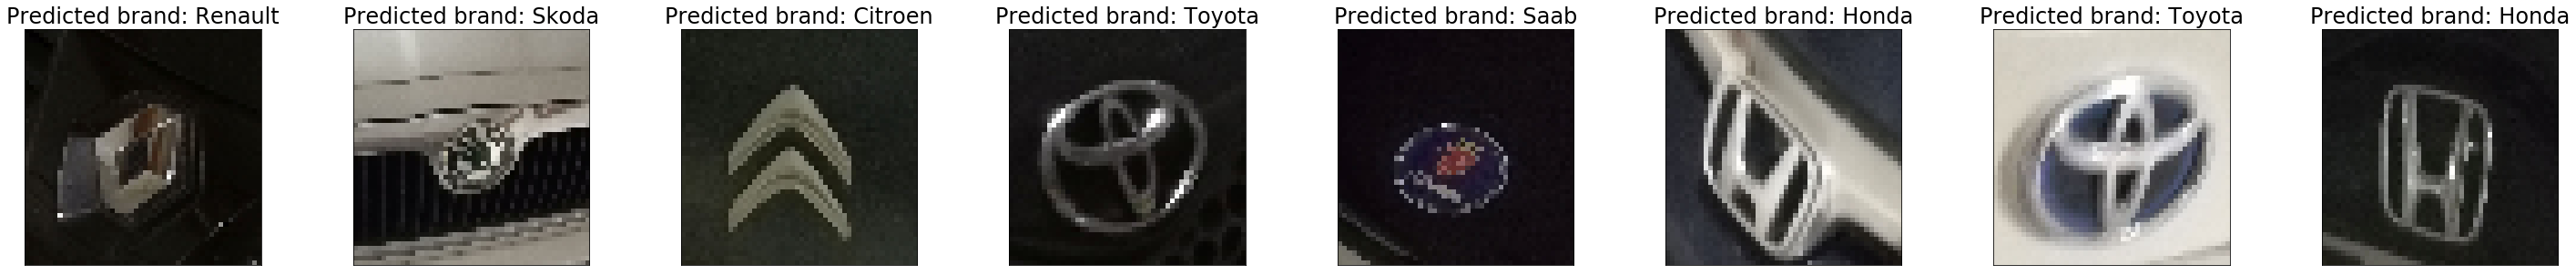

In [30]:
# Let's do some showcasing on-the-fly....
cols = 8
rows = 1
plt.figure(figsize=(cols * 5, rows * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(new_n_samples):
    plt.subplot(rows, cols, i + 1)
    im = Image.open(new_image_path+new_imgs[i]).convert("RGB")
    new_im = np.array(im.resize((50,50))).flatten()
    m = int(model.predict_classes(ImageConvert(1, new_im), verbose=0))
    plt.imshow(new_im.reshape(img_x, img_y, 3))
    plt.title('Predicted brand: '+cars[m], size=24)
    plt.xticks(())
    plt.yticks(())
plt.show()

# 100% success! :)

<hr>

# Examining the bad ones
Let's also see the wrongly predicted classes - try to judge what could be the reason - were they really "similar" to the predicted brands?

In [31]:
# let's extract the bad ones...
bad_ones = []

for i in range(len(X_test)):
    if y_test[i] != Y_pred[i]:
        bad_ones.append(i)

len(bad_ones)

232

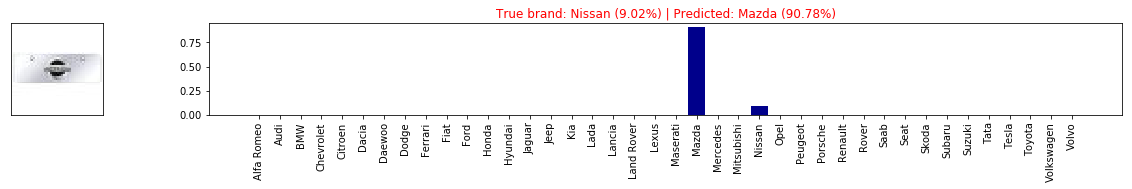

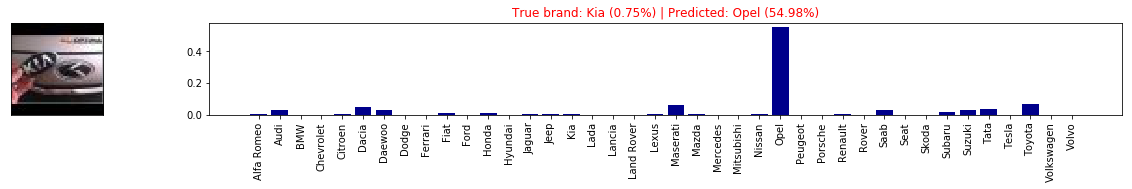

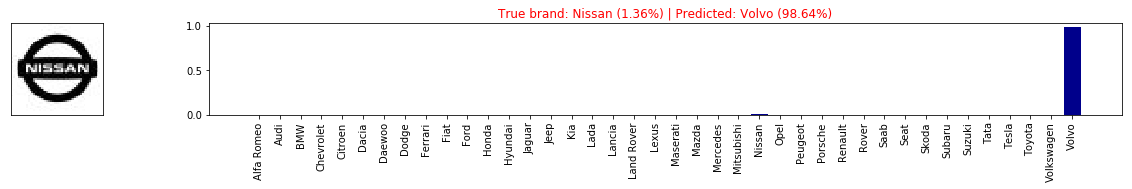

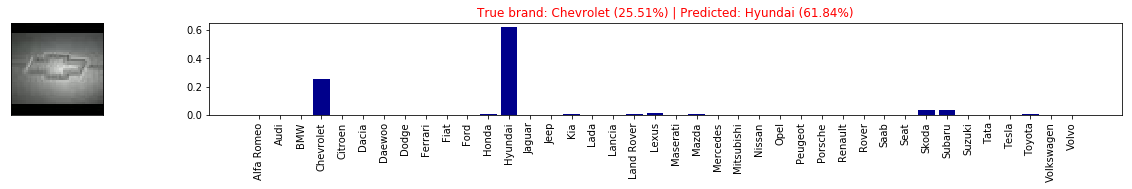

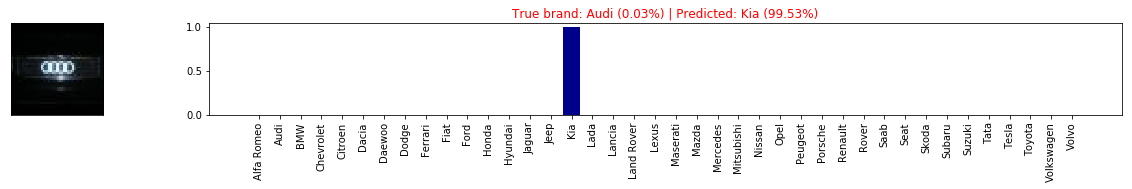

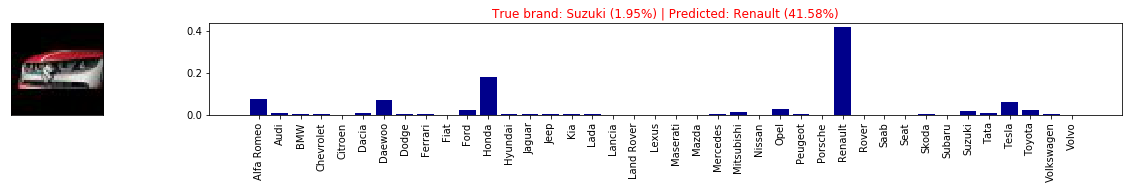

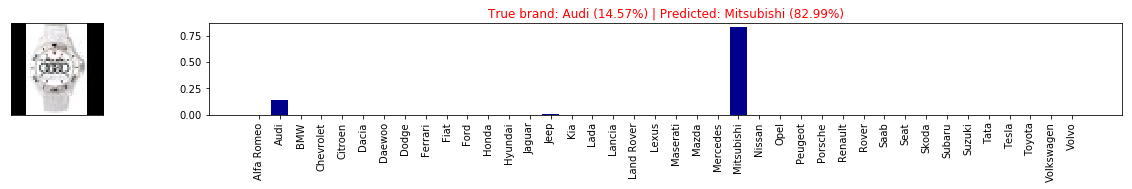

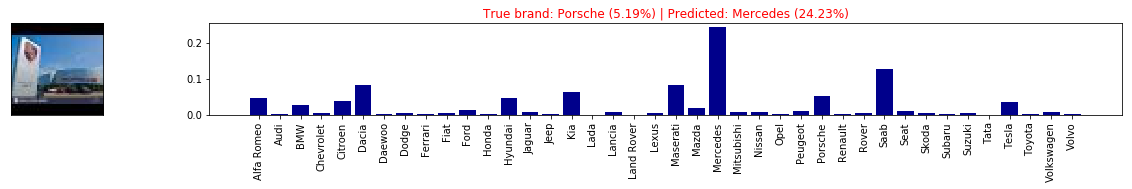

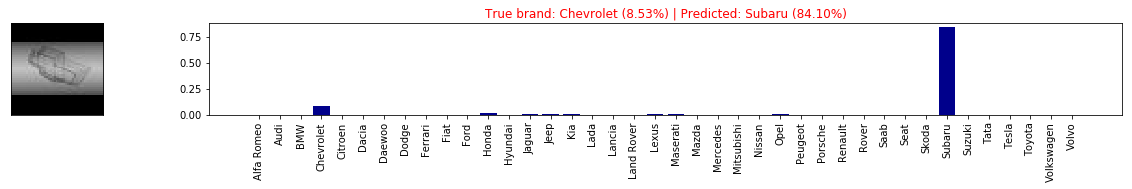

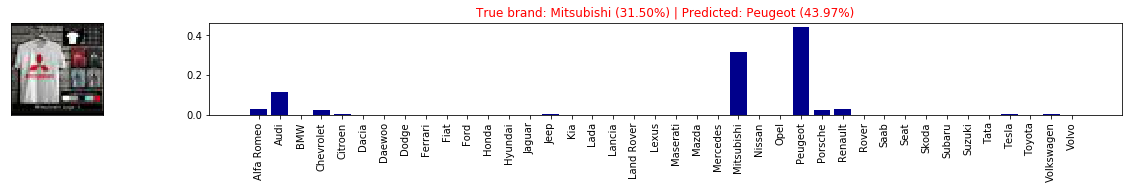

In [41]:
# ...now let's see them
samples = 10

fdict = {'fontsize': 12,
        'fontweight' : 'normal',
        'verticalalignment': 'baseline'}

for i in range(samples):
    
    # randomly choose only from the test set
    r = np.random.choice(bad_ones)
    
    # a list of probability predictions (brand classification)
    probs = model.predict_proba(X_test[r:r+1], verbose=0)[0]
    
    # we will still need the class predicted by the model
    j = int(model.predict_classes(X_test[r:r+1], verbose=0))
    
    x = range(len(cars))
    plt.figure(figsize=(20, samples * 2))
    
    # gridspec will handle the subplots nicely - we need only a small fraction for image show, but a long one for all 40 classes
    grid = gridspec.GridSpec(samples, 2, width_ratios=[1,9])
    plt.subplot(grid[0])
    
    # here we use X_test_img - the untouched copy of X_test
    plt.imshow(X_test_img[r].reshape(img_x, img_y, 3))
    
    # loose the ticks in the image subplots
    plt.xticks(())
    plt.yticks(())
    plt.subplot(grid[1])
    
    # the title shows the True brand and its predicted probability and the Predicted brand (and its predicted probability, too)
    plt.title('True brand: ' + cars[y_test[r]] + " ({:.2%})".format(probs[y_test[r]]) +
              ' | Predicted: ' + cars[j] + " ({:.2%})".format(probs[j]),
              color= 'Green' if cars[y_test[r]] == cars[j] else 'Red', fontdict=fdict) # again: GreenIsGood/RedIsBad
    plt.bar(x, probs, color='DarkBlue')
    plt.xticks(x, cars, rotation = 90)
plt.show()

Some of those examples were iffy for me too. But sometimes the neural network just totally missed!
Perhaps an even more diversified, less hand-picked and more noisy training dataset would help...

Anyhow, let's see the full statistics -- which were the most frequently confused brands? Which class datasets might need further augmenting and perhaps diversification before training the model again?

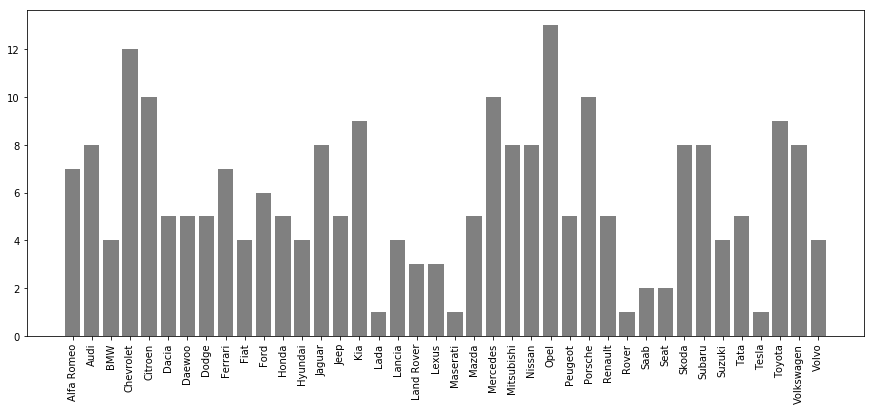

In [33]:
bad_list = [0] * len(cars)
for i in y_test[bad_ones]:
    bad_list[i] += 1
plt.figure(figsize=(15,6))
plt.bar(x, bad_list, color='Gray')
plt.xticks(x, cars, rotation = 90)
plt.show()

So, Mercedes and Porsche were most often confused with other brands, now let's see with which, each:

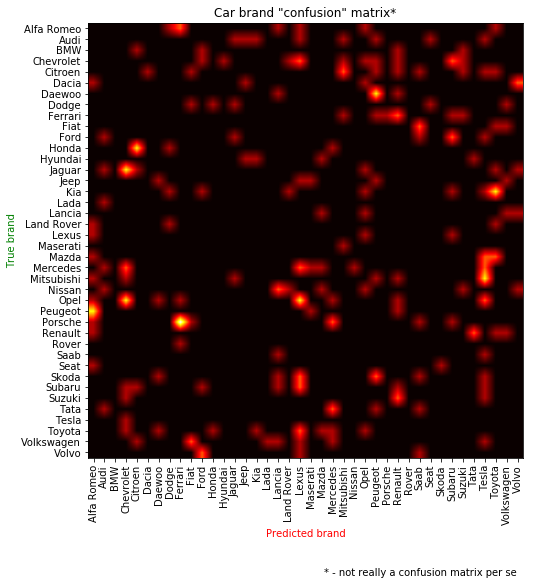

In [34]:
# Let's construct our own "confusion matrix" (not to be )
bD = np.zeros((40, 40))
for i in bad_ones:
    bD[y_test[i], Y_pred[i]] += 1

plt.figure(figsize=(8,8))
plt.imshow(bD, interpolation='bilinear', cmap='hot')
plt.xticks(x, cars, rotation=90)
plt.yticks(x, cars)
plt.title('Car brand "confusion" matrix*')
plt.xlabel('Predicted brand', color='Red')
plt.ylabel('True brand', color='Green')
plt.figtext(0.88,-0.08, '* - not really a confusion matrix per se', horizontalalignment='right')
plt.show()

The most significant error for CarL was mistaking Porsche for Ferrari and Jaguar for Chevrolet.
What's interesting - it doesn't necessarily work the other way round - Ferrari was most often mistaken for Renault